# 🧠 Análise de Dados de Jogadores de Futebol — Relação entre Estatísticas e Preço de Mercado

## 🎯 Objetivo da Análise

Nosso objetivo é identificar **jogadores com alto desempenho estatístico, mas com valores de mercado baixos**, ou seja, **potenciais contratações com ótimo custo-benefício**.

Essa análise pode ser muito útil para clubes que buscam reforços eficientes e acessíveis financeiramente.

Outras perguntas complementares:

- Como tratar os dados faltantes no dataset?
- Como identificar e remover estatísticas irrelevantes?
- Como montar o melhor time possível com um orçamento específico?
- Como balancear as estatísticas de jogadores com poucos dados coletados?

## 📂 Apresentação dos Datasets

O conjunto de dados utilizado nesta análise é proveniente da plataforma Kaggle, que reúne informações das fontes Sofascore e Transfermarkt, conhecidas por fornecerem estatísticas e valores de mercado detalhadas sobre o futebol. Embora o repositório contenha diversos arquivos, esta análise se concentrará exclusivamente nos dados estatísticos individuais dos jogadores referentes ao período de 13 de abril de 2024 a 12 de outubro de 2024.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

## 💲 DataSet dos Preços de mercado

In [ ]:
df_prices = pd.read_csv('/content/drive/MyDrive/2025.1/Ciências de Dados/DataSet/market_value.csv')
print(df_prices.shape)
df_prices

(33043, 9)


,x,y,mw,datum_mw,verein,age,wappen,player_id,player_name
0,1.202425e+12,50000.0,€50k,"Feb 8, 2008",Cruzeiro Esporte Clube,18,https://tmssl.akamaized.net//images/wappen/pro...,68097,Rafael
1,1.229036e+12,200000.0,€200k,"Dec 12, 2008",Cruzeiro Esporte Clube,19,NaN,68097,Rafael
2,1.254694e+12,800000.0,€800k,"Oct 5, 2009",Cruzeiro Esporte Clube,20,NaN,68097,Rafael
3,1.271282e+12,600000.0,€600k,"Apr 15, 2010",Cruzeiro Esporte Clube,20,NaN,68097,Rafael
4,1.275775e+12,300000.0,€300k,"Jun 6, 2010",Cruzeiro Esporte Clube,20,NaN,68097,Rafael
...,...,...,...,...,...,...,...,...,...
33038,1.649196e+12,300000.0,€300k,"Apr 6, 2022",Esporte Clube Juventude,34,NaN,110650,Ricardo Bueno
33039,1.660860e+12,300000.0,€300k,"Aug 19, 2022",Esporte Clube Juventude,35,NaN,110650,Ricardo Bueno
33040,1.668380e+12,250000.0,€250k,"Nov 14, 2022",Esporte Clube Juventude,35,NaN,110650,Ricardo Bueno
33041,1.689631e+12,250000.0,€250k,"Jul 18, 2023",AD Confiança,35,https://tmssl.akamaized.net//images/wappen/pro...,110650,Ricardo Bueno


## 📉 DataSet das Estatisticas do Jogador  

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/2025.1/Ciências de Dados/DataSet/statistics_player.csv")
print(df.shape)
df.head()

(39861, 53)


,id_partida,data_jogo,campeonato,team,team_name,name,position,jerseyNumber,height,country,dateOfBirth,age,totalPass,accuratePass,totalLongBalls,accurateLongBalls,goalAssist,goals,minutesPlayed,rating,touches,possessionLostCtrl,expectedGoals,expectedAssists,aerialLost,aerialWon,duelLost,duelWon,onTargetScoringAttempt,totalClearance,totalTackle,wasFouled,fouls,totalCross,accurateCross,outfielderBlock,goodHighClaim,savedShotsFromInsideTheBox,saves,challengeLost,totalContest,wonContest,bigChanceMissed,shotOffTarget,interceptionWon,keyPass,dispossessed,blockedScoringAttempt,bigChanceCreated,penaltyWon,totalOffside,goalsPrevented,penaltyConceded
0,12117250,2024-09-29,Brasileirão Série A,home,São Paulo,Rafael,G,23.0,192.0,Brazil,1989-06-22,35.0,23.0,21.0,7.0,5.0,0.0,NaN,90.0,6.9,34.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.1379,NaN
1,12117250,2024-09-29,Brasileirão Série A,home,São Paulo,Rafinha,D,13.0,172.0,Brazil,1985-09-06,39.0,38.0,33.0,6.0,3.0,0.0,NaN,70.0,6.8,46.0,7.0,NaN,0.101048,1.0,NaN,2.0,NaN,NaN,2.0,NaN,NaN,1.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12117250,2024-09-29,Brasileirão Série A,home,São Paulo,Robert Arboleda,D,5.0,187.0,Ecuador,1991-10-21,32.0,42.0,34.0,5.0,2.0,0.0,1.0,90.0,7.5,52.0,8.0,0.0770,NaN,1.0,3.0,2.0,5.0,1.0,6.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12117250,2024-09-29,Brasileirão Série A,home,São Paulo,Alan Franco,D,28.0,183.0,Argentina,1996-10-10,28.0,29.0,24.0,4.0,1.0,0.0,NaN,90.0,6.1,40.0,8.0,0.4907,NaN,4.0,NaN,7.0,1.0,NaN,3.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12117250,2024-09-29,Brasileirão Série A,home,São Paulo,Welington,D,6.0,170.0,Brazil,2001-02-18,23.0,27.0,23.0,5.0,4.0,0.0,NaN,84.0,6.8,44.0,9.0,NaN,NaN,1.0,2.0,4.0,8.0,NaN,2.0,2.0,4.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 🛠️ Metodologia

Os dois datasets serão unidos em um único conjunto de dados, facilitando a análise integrada das informações.




### Merge dos dois DataSet

- Padronização no nomes: Realizado a alteração de todos os termos do dataset para associação nos dois datasets;
- Conversão dos valores de mercado: Realizada a conversão de Euro para Real


In [ ]:
!pip install unidecode

In [ ]:
from unidecode import unidecode

def parse_euro_value(value):
    cotacao_euro = 6.39  # Cotação fixa do euro para real

    if isinstance(value, str):
        value = value.replace('€', '').lower().strip()
        if value == '-' or value == '':
            return None  # ou use "R$ 0,00" se preferir zero formatado
        if 'm' in value:
            valor_em_euros = float(value.replace('m', '')) * 1_000_000
        elif 'k' in value:
            valor_em_euros = float(value.replace('k', '')) * 1_000
        else:
            valor_em_euros = float(value)
    elif pd.isna(value):
        return None
    else:
        valor_em_euros = float(value)

    valor_em_reais = valor_em_euros * cotacao_euro
    return f'R$ {valor_em_reais:,.2f}'.replace(',', 'v').replace('.', ',').replace('v', '.')

# Função auxiliar para padronizar strings
def normalize_string(s):
    if pd.isna(s):
        return ''
    return unidecode(str(s).strip().lower())

# Padronizar os nomes dos jogadores e times em ambos os DataFrames
df['name_norm'] = df['name'].apply(normalize_string)
df['team_name_norm'] = df['team_name'].apply(normalize_string)

df_prices['player_name_norm'] = df_prices['player_name'].apply(normalize_string)
df_prices['verein_norm'] = df_prices['verein'].apply(normalize_string)

# Converter a coluna de data
df_prices['datum_mw'] = pd.to_datetime(df_prices['datum_mw'], errors='coerce')

# Obter a linha mais recente para cada jogador (já normalizado)
latest_market_values = df_prices.sort_values('datum_mw').dropna(subset=['datum_mw'])
latest_market_values = latest_market_values.groupby('player_name_norm').last().reset_index()

# Criar o dicionário com nome normalizado -> valor mais recente
market_value_dict = dict(zip(latest_market_values['player_name_norm'], latest_market_values['mw']))

# Mapear os valores no df_stats com base no nome padronizado
df['valor_mercado_mais_recente(R$)'] = df['name_norm'].map(market_value_dict)
df['valor_mercado_mais_recente(R$)'] = df['valor_mercado_mais_recente(R$)'].apply(parse_euro_value)
df.drop(['name_norm','team_name_norm'],axis=1,inplace=True)


In [ ]:
df.head()

,id_partida,data_jogo,campeonato,team,team_name,name,position,jerseyNumber,height,country,dateOfBirth,age,totalPass,accuratePass,totalLongBalls,accurateLongBalls,goalAssist,goals,minutesPlayed,rating,touches,possessionLostCtrl,expectedGoals,expectedAssists,aerialLost,aerialWon,duelLost,duelWon,onTargetScoringAttempt,totalClearance,totalTackle,wasFouled,fouls,totalCross,accurateCross,outfielderBlock,goodHighClaim,savedShotsFromInsideTheBox,saves,challengeLost,totalContest,wonContest,bigChanceMissed,shotOffTarget,interceptionWon,keyPass,dispossessed,blockedScoringAttempt,bigChanceCreated,penaltyWon,totalOffside,goalsPrevented,penaltyConceded,valor_mercado_mais_recente(R$)
0,12117250,2024-09-29,Brasileirão Série A,home,São Paulo,Rafael,G,23.0,192.0,Brazil,1989-06-22,35.0,23.0,21.0,7.0,5.0,0.0,NaN,90.0,6.9,34.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.1379,NaN,"R$ 2.556.000,00"
1,12117250,2024-09-29,Brasileirão Série A,home,São Paulo,Rafinha,D,13.0,172.0,Brazil,1985-09-06,39.0,38.0,33.0,6.0,3.0,0.0,NaN,70.0,6.8,46.0,7.0,NaN,0.101048,1.0,NaN,2.0,NaN,NaN,2.0,NaN,NaN,1.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"R$ 1.278.000,00"
2,12117250,2024-09-29,Brasileirão Série A,home,São Paulo,Robert Arboleda,D,5.0,187.0,Ecuador,1991-10-21,32.0,42.0,34.0,5.0,2.0,0.0,1.0,90.0,7.5,52.0,8.0,0.0770,NaN,1.0,3.0,2.0,5.0,1.0,6.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"R$ 7.668.000,00"
3,12117250,2024-09-29,Brasileirão Série A,home,São Paulo,Alan Franco,D,28.0,183.0,Argentina,1996-10-10,28.0,29.0,24.0,4.0,1.0,0.0,NaN,90.0,6.1,40.0,8.0,0.4907,NaN,4.0,NaN,7.0,1.0,NaN,3.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"R$ 19.170.000,00"
4,12117250,2024-09-29,Brasileirão Série A,home,São Paulo,Welington,D,6.0,170.0,Brazil,2001-02-18,23.0,27.0,23.0,5.0,4.0,0.0,NaN,84.0,6.8,44.0,9.0,NaN,NaN,1.0,2.0,4.0,8.0,NaN,2.0,2.0,4.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"R$ 22.365.000,00"


## 1. **limpeza do DataSet**

### 1.1 **Seleção de variáveis relevantes**:

*Análise das colunas do DataFrame: serão excluídas as colunas que não são relevantes para a análise, mantendo apenas aquelas que contribuem com informações úteis sobre o jogadores.*


| Variável                       | Significado                                                             |
| ------------------------------ | ----------------------------------------------------------------------- |
| **id\_partida**                | Identificador único da partida.                                         |
| **data\_jogo**                 | Data em que a partida foi realizada.                                    |
| **campeonato**                 | Competição em que o jogo foi disputado (ex: Brasileirão, Libertadores). |
| **team**                       | ID ou código do time do jogador.                                        |
| **team\_name**                 | Nome do time do jogador.                                                |
| **name**                       | Nome do jogador.                                                        |
| **position**                   | Posição em campo (ex: Goleiro, Zagueiro, Meia, Atacante).               |
| **jerseyNumber**               | Número da camisa usado pelo jogador na partida.                         |
| **height**                     | Altura do jogador (em cm ou metros).                                    |
| **country**                    | País de origem do jogador.                                              |
| **dateOfBirth**                | Data de nascimento do jogador.                                          |
| **age**                        | Idade atual do jogador (em anos).                                       |
| **totalPass**                  | Número total de passes tentados.                                        |
| **accuratePass**               | Total de passes certos (conectados com companheiros).                   |
| **totalLongBalls**             | Total de bolas longas (passes de longa distância) tentadas.             |
| **accurateLongBalls**          | Total de bolas longas que chegaram ao destino.                          |
| **goalAssist**                 | Assistências para gol feitas pelo jogador.                              |
| **goals**                      | Total de gols marcados pelo jogador.                                    |
| **minutesPlayed**              | Total de minutos em campo (tempo jogado).                               |
| **rating**                     | Avaliação geral do desempenho do jogador (ex: Sofascore).               |
| **touches**                    | Número de vezes que o jogador tocou na bola.                            |
| **possessionLostCtrl**         | Perdas de posse ao tentar controlar a bola.                             |
| **expectedGoals**              | Gols esperados com base na qualidade das chances criadas.               |
| **expectedAssists**            | Assistências esperadas com base nas chances criadas.                    |
| **aerialLost**                 | Disputas aéreas perdidas (jogo de cabeça).                              |
| **aerialWon**                  | Disputas aéreas vencidas.                                               |
| **duelLost**                   | Duelos no chão perdidos contra adversários.                             |
| **duelWon**                    | Duelos no chão vencidos.                                                |
| **onTargetScoringAttempt**     | Finalizações no gol (com direção ao gol).                               |
| **totalClearance**             | Cortes ou afastamentos da bola em situação de risco.                    |
| **totalTackle**                | Total de desarmes tentados.                                             |
| **wasFouled**                  | Número de vezes que o jogador sofreu falta.                             |
| **fouls**                      | Número de faltas cometidas.                                             |
| **totalCross**                 | Total de cruzamentos tentados.                                          |
| **accurateCross**              | Cruzamentos que chegaram ao destino.                                    |
| **outfielderBlock**            | Bloqueios realizados por jogadores de linha (contra finalizações).      |
| **goodHighClaim**              | Cruzamentos interceptados com sucesso pelo goleiro.                     |
| **savedShotsFromInsideTheBox** | Defesas de finalizações feitas dentro da área.                          |
| **saves**                      | Total de defesas feitas pelo goleiro.                                   |
| **challengeLost**              | Disputas físicas ou técnicas perdidas.                                  |
| **totalContest**               | Total de disputas de bola (físicas ou técnicas).                        |
| **wonContest**                 | Disputas de bola vencidas.                                              |
| **bigChanceMissed**            | Oportunidades claras de gol desperdiçadas.                              |
| **shotOffTarget**              | Finalizações para fora do gol.                                          |
| **interceptionWon**            | Interceptações de passes do adversário.                                 |
| **keyPass**                    | Passes que resultaram em uma oportunidade de finalização.               |
| **dispossessed**               | Vezes em que o jogador perdeu a posse da bola.                          |
| **blockedScoringAttempt**      | Finalizações bloqueadas por defensores adversários.                     |
| **bigChanceCreated**           | Grandes chances de gol criadas pelo jogador.                            |
| **penaltyWon**                 | Pênaltis sofridos pelo jogador.                                         |
| **totalOffside**               | Vezes em que o jogador foi flagrado em posição de impedimento.          |
| **goalsPrevented**             | Gols evitados além da média esperada (geralmente por goleiros).         |
| **penaltyConceded**            | Pênaltis cometidos pelo jogador.                                        |


In [ ]:
colunas_descartas = ['id_partida','data_jogo','jerseyNumber','dateOfBirth','team']
df.drop(colunas_descartas,axis=1,inplace=True)
print(f'Colunas Descartadas {colunas_descartas}')

Colunas Descartadas ['id_partida', 'data_jogo', 'jerseyNumber', 'dateOfBirth', 'team']


### 1.2 **Remoção dos jogadores que não jogaram**:
   - Serão descartados os jogadores que apresentarem todas as estatísticas nulas em determinada partida, o que indica que não participaram do jogo.

In [ ]:
# Detecta linhas que têm NaN em **todas** as colunas da 12 em diante
linhas_so_com_nan = df.iloc[:, 7:-1].isna().all(axis=1)

# Remove essas linhas
df_titulares = df[~linhas_so_com_nan]

In [ ]:
df_titulares.shape

(27765, 49)

- Remoção de jogadores que não possuem preço de mercado

In [ ]:
df_titulares = df_titulares.dropna(subset=['valor_mercado_mais_recente(R$)'])

In [ ]:
df_titulares.shape

(22526, 49)

### 1.3 **Separação e Agrupamento**:

Foram separados os jogadores por competições nacionais e internacionais, agrupando linhas com duplicatas de jogadores

#### Separação

In [ ]:
# Jogos internacionais (Libertadores e Sul-Americana)
df_internacionais = df_titulares[df_titulares['campeonato'].str.contains('Libertadores|Sudamericana', case=False)]

# Jogos nacionais (Brasileirão e Copa do Brasil)
df_nacionais = df_titulares[df_titulares['campeonato'].str.contains('Brasileirão|Copa do Brasil', case=False)]

In [ ]:
df_internacionais.shape

(5842, 49)

In [ ]:
df_nacionais.shape

(16684, 49)

#### Agrupamento

In [ ]:
# Identifica colunas numéricas e não numéricas
colunas_numericas = df_nacionais.select_dtypes(include='number').columns
colunas_nao_numericas = df_nacionais.select_dtypes(exclude='number').columns

# Define a agregação para cada tipo de coluna
agg_dict = {col: 'first' for col in colunas_nao_numericas}
agg_dict.update({col: 'mean' for col in colunas_numericas})

# Altera minutesPlayed para ser somado
agg_dict['minutesPlayed'] = 'sum'

# Agrupamento
df_agrupado_nacional = df_nacionais.groupby(['name', 'team_name'], as_index=False).agg(agg_dict)

# Identifica colunas numéricas e não numéricas
colunas_numericas_inter = df_internacionais.select_dtypes(include='number').columns
colunas_nao_numericas_inter = df_internacionais.select_dtypes(exclude='number').columns

# Define a agregação para cada tipo de coluna
agg_dict = {col: 'first' for col in colunas_nao_numericas_inter}
agg_dict.update({col: 'mean' for col in colunas_numericas_inter})

# Altera minutesPlayed para ser somado
agg_dict['minutesPlayed'] = 'sum'

# AgrupamentoItem da lista
df_agrupado_internacional = df_internacionais.groupby(['name', 'team_name'], as_index=False).agg(agg_dict)


In [ ]:
df_agrupado_nacional.shape

(1090, 49)

In [ ]:
df_agrupado_internacional.shape

(1251, 49)

### 1.4 - Tratamento de valores nulos

Adotamos o criterio de retirada do jogador caso possuisse valores nulos nas seguintes colunas:
- Country;
- Height;
- Age;
- Position;

E para as estatisticas nulas foram preenchidos com valor 0

#### Nacionais

In [ ]:
# df com jogos nacionais
missing = df_agrupado_nacional.iloc[:,:].isnull().sum()
print(missing[missing > 0])
df_agrupado_nacional = df_agrupado_nacional.dropna(subset=['country', 'height', 'age'])
df_agrupado_nacional = df_agrupado_nacional.fillna(0)

country                          1
height                          15
age                              1
totalPass                        1
accuratePass                     2
totalLongBalls                  49
accurateLongBalls              108
goalAssist                      22
goals                          608
rating                           4
touches                          1
possessionLostCtrl               4
expectedGoals                  613
expectedAssists                586
aerialLost                     115
aerialWon                      120
duelLost                        53
duelWon                         30
onTargetScoringAttempt         331
totalClearance                 108
totalTackle                    121
wasFouled                      103
fouls                          127
totalCross                     237
accurateCross                  445
outfielderBlock                422
goodHighClaim                 1026
savedShotsFromInsideTheBox    1020
saves               

#### Internacionais

In [ ]:
# df com jogos internacionais
missing = df_agrupado_internacional.iloc[:,:].isnull().sum()
print(missing[missing > 0])
df_agrupado_internacional = df_agrupado_internacional.dropna(subset=['country', 'height', 'age','position'])
df_agrupado_internacional = df_agrupado_internacional.fillna(0)


position                         1
country                          5
height                          32
age                              2
totalPass                       12
accuratePass                    16
totalLongBalls                 127
accurateLongBalls              225
goalAssist                     153
goals                          964
rating                          12
touches                          5
possessionLostCtrl              21
expectedGoals                  760
expectedAssists                695
aerialLost                     241
aerialWon                      242
duelLost                        99
duelWon                         63
onTargetScoringAttempt         631
totalClearance                 249
totalTackle                    248
wasFouled                      280
fouls                          261
totalCross                     446
accurateCross                  716
outfielderBlock                755
goodHighClaim                 1183
savedShotsFromInside

### 1.5 - Retirada de jogadores com pouca minutagem

#### Jogos Nacionais

Foi adotado o seguinte criterio para remoção dos jogadores:
- Jogadores que possuiam minutos jogados menores que a media + (desvio padrão/2)

Média dos minutos Jogados: 986.48
Desvio padrão dos minutos jogados: 783.52


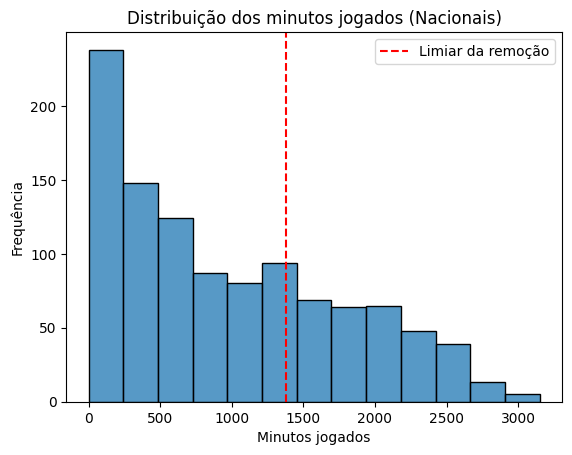

(1074, 49)

In [ ]:
# Estatísticas
media_minutos = (df_agrupado_nacional['minutesPlayed']).mean()
desvio_minutos = (df_agrupado_nacional['minutesPlayed']).std()

print(f'Média dos minutos Jogados: {media_minutos:.2f}')
print(f'Desvio padrão dos minutos jogados: {desvio_minutos:.2f}')

# Histograma
sns.histplot(df_agrupado_nacional['minutesPlayed'])

# Linha da média - desvio padrão
plt.axvline(media_minutos + desvio_minutos/2, color='red', linestyle='--', label='Limiar da remoção')

# Legenda e título
plt.legend()
plt.title('Distribuição dos minutos jogados (Nacionais)')
plt.xlabel('Minutos jogados')
plt.ylabel('Frequência')

plt.show()

df_agrupado_nacional.shape

In [ ]:
df_agrupado_nacional = df_agrupado_nacional[df_agrupado_nacional['minutesPlayed'] >= (media_minutos + desvio_minutos/2)]
df_agrupado_nacional.shape

(333, 49)

#### Jogos Internacionais

Foi adotado o seguinte criterio para remoção dos jogadores:

- Jogadores que possuiam minutos jogados menores que a media + (desvio padrão/2)

Média dos minutos Jogados: 309.51
Desvio padrão dos minutos jogados: 213.20


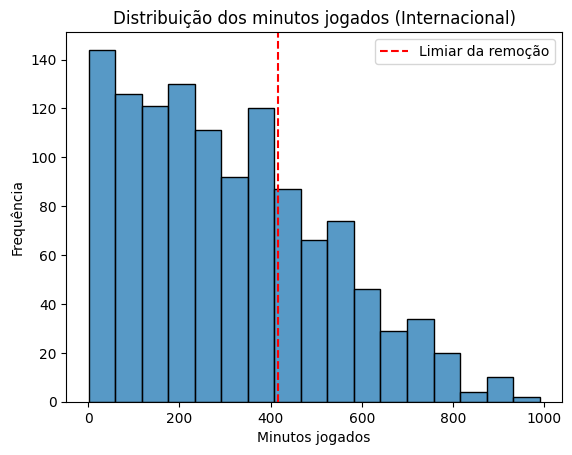

(1216, 49)

In [ ]:
# Estatísticas
media_minutos = (df_agrupado_internacional['minutesPlayed']).mean()
desvio_minutos = (df_agrupado_internacional['minutesPlayed']).std()

print(f'Média dos minutos Jogados: {media_minutos:.2f}')
print(f'Desvio padrão dos minutos jogados: {desvio_minutos:.2f}')

# Histograma
sns.histplot(df_agrupado_internacional['minutesPlayed'])

# Linha da média - desvio padrão
plt.axvline(media_minutos + desvio_minutos/2, color='red', linestyle='--', label='Limiar da remoção')

# Legenda e título
plt.legend()
plt.title('Distribuição dos minutos jogados (Internacional)')
plt.xlabel('Minutos jogados')
plt.ylabel('Frequência')

plt.show()

df_agrupado_internacional.shape

In [ ]:
df_agrupado_internacional = df_agrupado_internacional[df_agrupado_internacional['minutesPlayed'] >= (media_minutos + desvio_minutos/2)]
df_agrupado_internacional.shape

(364, 49)

## 2. **🔍 Insights e Análises**:
   

### 2.1 Analises por posições

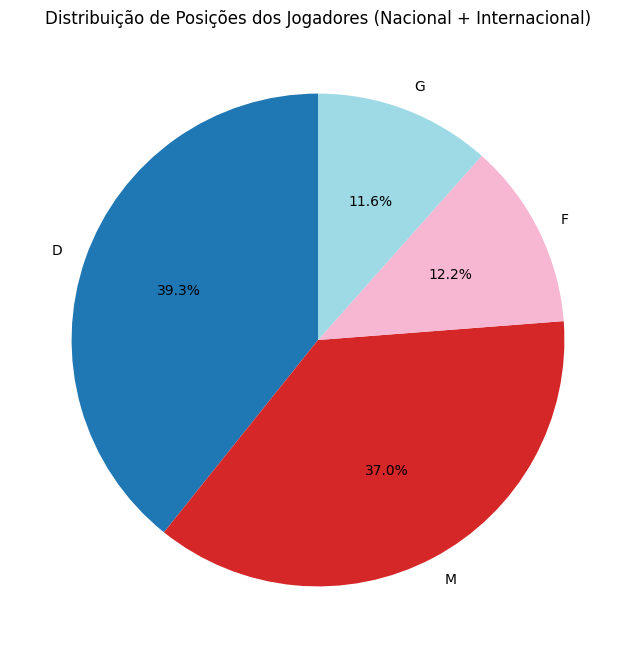

In [ ]:
# Concatenar os DataFrames (somando as linhas)
df_combinado = pd.concat([df_agrupado_nacional, df_agrupado_internacional])

# Remover duplicatas de jogadores, mantendo a primeira ocorrência (pode escolher 'name' ou 'player_id')
df_unico = df_combinado.drop_duplicates(subset=['name','team_name'])

# Contar quantos jogadores por posição
pos_counts = df_unico['position'].value_counts()

# Plotar gráfico de pizza
plt.figure(figsize=(8, 8))
pos_counts.plot.pie(autopct='%1.1f%%', startangle=90, cmap='tab20')
plt.title('Distribuição de Posições dos Jogadores (Nacional + Internacional)')
plt.ylabel('')  # Remove o label do eixo y para ficar mais limpo
plt.show()



*   G - Goleiro
*   M - Meia
*   D - Zagueiro
*   F - Atacante



##### Criação do Score do jogador

Criação de uma nova variavel (Score) para ajudar no ranking dos jogadores:
- Definições de variaveis boas e ruins para a posição;
- Atribuição de pesos de acordo com o grau de importancia da variavel;
- Normalização das variaveis (Dataset);
- Valor do Score: Multiplicação das variaveis pelos pessos atribuidos com uma normalização da escala (0 a 100);
- Score 100: Jogador com as melhores estatisticas;
- Score 0: Jogador com as piores estatisticas;

In [ ]:
def score_goleiro(df_goleiros:pd.DataFrame)->pd.DataFrame:

  # Definição de pesos
  pesos_bons = {
      'rating': 0.10,
      'saves': 0.20,
      'savedShotsFromInsideTheBox': 0.10,
      'goodHighClaim': 0.10,
      'accuratePass': 0.05,
      'height': 0.15,
      'goalsPrevented':0.10
  }

  pesos_ruins = {
      'age': 0.15,
      'penaltyConceded': 0.05
  }


  # Junta todas as colunas
  todas_colunas = list(pesos_bons.keys()) + list(pesos_ruins.keys())
  df_filtrado = df_goleiros[todas_colunas].copy()

  # Padronização
  scaler = StandardScaler()
  df_padronizado = pd.DataFrame(scaler.fit_transform(df_filtrado), columns=todas_colunas, index=df_goleiros.index)

  # Inverte os sinais das colunas negativas
  for coluna in pesos_ruins:
      df_padronizado[coluna] *= -1

  # Aplica os pesos
  for coluna, peso in {**pesos_bons, **pesos_ruins}.items():
      df_padronizado[coluna] *= peso

  # Score total
  df_goleiros['score_total'] = df_padronizado.sum(axis=1)

  # Normaliza entre 0 e 100
  score_min = df_goleiros['score_total'].min()
  score_max = df_goleiros['score_total'].max()
  df_goleiros['score_normalizado'] = 100 * (df_goleiros['score_total'] - score_min) / (score_max - score_min)

  # Ordena
  df_top10 = df_goleiros.sort_values(by='score_normalizado', ascending=False)[
      ['name', 'team_name', 'score_normalizado','valor_mercado_mais_recente(R$)'] + todas_colunas
  ]

  # Exibe
  return df_top10

In [ ]:
def score_defensores(df_defensores:pd.DataFrame)->pd.DataFrame:
  pesos_boas = {
    'height': 0.05,
    'accuratePass': 0.05,
    'accurateLongBalls': 0.04,
    'goalAssist': 0.01,
    'goals': 0.01,
    'rating': 0.06,
    'aerialWon': 0.05,
    'duelWon': 0.07,
    'onTargetScoringAttempt': 0.01,
    'totalClearance': 0.10,
    'totalTackle': 0.07,
    'wasFouled': 0.01,
    'accurateCross': 0.01,
    'outfielderBlock': 0.04,
    'wonContest': 0.04,
    'shotOffTarget': 0.01,
    'interceptionWon': 0.08,
    'keyPass': 0.01,
    'blockedScoringAttempt': 0.06,
    'bigChanceCreated': 0.01,
    'penaltyWon': 0.01
  }  # total: 0.70

  pesos_ruins = {
    'age': 0.10,
    'possessionLostCtrl': 0.05,
    'aerialLost': 0.03,
    'duelLost': 0.03,
    'fouls': 0.03,
    'challengeLost': 0.03,
    'bigChanceMissed': 0.01,
    'dispossessed': 0.03,
    'totalOffside': 0.01,
    'penaltyConceded': 0.02
  }  # total: 0.30


  # Junta todas as colunas
  todas_colunas = list(pesos_boas.keys()) + list(pesos_ruins.keys())
  df_filtrado = df_defensores[todas_colunas].copy()

  # Padronização
  scaler = StandardScaler()
  df_padronizado = pd.DataFrame(scaler.fit_transform(df_filtrado), columns=todas_colunas, index=df_defensores.index)

  # Inverte os sinais das colunas negativas
  for coluna in pesos_ruins:
      df_padronizado[coluna] *= -1

  # Aplica os pesos
  for coluna, peso in {**pesos_boas, **pesos_ruins}.items():
      df_padronizado[coluna] *= peso

  # Score total
  df_defensores['score_total'] = df_padronizado.sum(axis=1)

  # Normaliza entre 0 e 100
  score_min = df_defensores['score_total'].min()
  score_max = df_defensores['score_total'].max()
  df_defensores['score_normalizado'] = 100 * (df_defensores['score_total'] - score_min) / (score_max - score_min)

  # Ordena
  df_top10 = df_defensores.sort_values(by='score_normalizado', ascending=False)[
      ['name', 'team_name', 'score_normalizado','valor_mercado_mais_recente(R$)'] + todas_colunas
  ]

  return df_top10

In [ ]:
def score_meio_campo(df_meias: pd.DataFrame) -> pd.DataFrame:
  pesos_bons = {
  'accuratePass': 0.07,
  'keyPass': 0.06,
  'bigChanceCreated': 0.05,
  'accurateLongBalls': 0.06,
  'goalAssist': 0.06,
  'goals': 0.03,
  'rating': 0.09,
  'interceptionWon': 0.03,
  'duelWon': 0.03,
  'wasFouled': 0.02,
  'aerialWon': 0.02,
  'totalTackle': 0.03,
  'outfielderBlock': 0.01,
  'wonContest': 0.02,
  'accurateCross': 0.01,
  'height': 0.01,
  'onTargetScoringAttempt': 0.02,
  'blockedScoringAttempt': 0.01,
  'penaltyWon': 0.01,
  'expectedGoals': 0.07,
  'expectedAssists': 0.07
  }  # total: 0.70

  pesos_ruins = {
  'age': 0.12,
  'possessionLostCtrl': 0.05,
  'dispossessed': 0.04,
  'duelLost': 0.03,
  'fouls': 0.02,
  'challengeLost': 0.03,
  'bigChanceMissed': 0.02,
  'aerialLost': 0.02,
  'totalOffside': 0.01,
  'penaltyConceded': 0.01
  }  # total: 0.30

  todas_colunas = list(pesos_bons.keys()) + list(pesos_ruins.keys())
  df_filtrado = df_meias[todas_colunas].copy()

  print("Tem NaN?", df_filtrado.isna().sum().sum() > 0)

  scaler = StandardScaler()
  df_padronizado = pd.DataFrame(scaler.fit_transform(df_filtrado), columns=todas_colunas, index=df_meias.index)

  for coluna in pesos_ruins:
      df_padronizado[coluna] *= -1

  for coluna, peso in {**pesos_bons, **pesos_ruins}.items():
      df_padronizado[coluna] *= peso

  df_meias['score_total'] = df_padronizado.sum(axis=1)

  score_min = df_meias['score_total'].min()
  score_max = df_meias['score_total'].max()
  df_meias['score_normalizado'] = 100 * (df_meias['score_total'] - score_min) / (score_max - score_min)

  df_top10 = df_meias.sort_values(by='score_normalizado', ascending=False)[
      ['name', 'team_name', 'score_normalizado','valor_mercado_mais_recente(R$)'] + todas_colunas
  ]

  return df_top10


In [ ]:
def score_atacantes(df_atacantes: pd.DataFrame) -> pd.DataFrame:
  pesos_bons = {
  'goals': 0.10,
  'expectedGoals': 0.09,
  'onTargetScoringAttempt': 0.07,
  'bigChanceCreated': 0.05,
  'expectedAssists': 0.05,
  'goalAssist': 0.05,
  'keyPass': 0.04,
  'accuratePass': 0.04,
  'rating': 0.09,  # ↑ mais peso
  'penaltyWon': 0.03,
  'wasFouled': 0.02,
  'duelWon': 0.02,
  'aerialWon': 0.01,
  'accurateCross': 0.01,
  'accurateLongBalls': 0.01,
  'blockedScoringAttempt': 0.01,
  'height': 0.01  # ↑ mais peso
  }  # total: 0.70

  pesos_ruins = {
  'age': 0.10,  # ↑ mais peso
  'possessionLostCtrl': 0.06,
  'dispossessed': 0.05,
  'bigChanceMissed': 0.04,
  'duelLost': 0.02,
  'fouls': 0.01,
  'challengeLost': 0.01,
  'totalOffside': 0.01
  }  # total: 0.30

  todas_colunas = list(pesos_bons.keys()) + list(pesos_ruins.keys())
  df_filtrado = df_atacantes[todas_colunas].copy()

  print("Tem NaN?", df_filtrado.isna().sum().sum() > 0)

  scaler = StandardScaler()
  df_padronizado = pd.DataFrame(scaler.fit_transform(df_filtrado), columns=todas_colunas, index=df_atacantes.index)

  for coluna in pesos_ruins:
      df_padronizado[coluna] *= -1

  for coluna, peso in {**pesos_bons, **pesos_ruins}.items():
      df_padronizado[coluna] *= peso

  df_atacantes['score_total'] = df_padronizado.sum(axis=1)

  score_min = df_atacantes['score_total'].min()
  score_max = df_atacantes['score_total'].max()
  df_atacantes['score_normalizado'] = 100 * (df_atacantes['score_total'] - score_min) / (score_max - score_min)

  df_top10 = df_atacantes.sort_values(by='score_normalizado', ascending=False)[
      ['name', 'team_name', 'score_normalizado','valor_mercado_mais_recente(R$)'] + todas_colunas
  ]

  return df_top10


#### Goleiros

- Obtenção dos goleiros tanto de competições nacionais como o das internacionais

In [ ]:
df_goleiros_nacional = df_agrupado_nacional[df_agrupado_nacional['position'] == 'G']
df_goleiros_internacional = df_agrupado_internacional[df_agrupado_internacional['position'] == 'G']

##### Ranking dos melhores goleiros de torneios nacionais

In [ ]:
df_top_goleiros_nacionais = score_goleiro(df_goleiros_nacional)
df_top_goleiros_nacionais.head(10)

<ipython-input-504-2c7078ff7bc5>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_goleiros['score_total'] = df_padronizado.sum(axis=1)
<ipython-input-504-2c7078ff7bc5>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_goleiros['score_normalizado'] = 100 * (df_goleiros['score_total'] - score_min) / (score_max - score_min)


,name,team_name,score_normalizado,valor_mercado_mais_recente(R$),rating,saves,savedShotsFromInsideTheBox,goodHighClaim,accuratePass,height,goalsPrevented,age,penaltyConceded
402,Hugo Souza,Corinthians,100.000000,"R$ 25.560.000,00",7.215789,4.166667,2.176471,1.100000,14.631579,199.0,0.195750,25.0,0.0
471,John Victor,Botafogo,91.283428,"R$ 22.365.000,00",7.265517,3.296296,2.227273,1.400000,22.931034,197.0,0.368674,28.0,0.0
657,Marcos Felipe,Bahia,87.012339,"R$ 12.780.000,00",7.297143,3.343750,2.555556,1.952381,27.485714,189.0,0.074883,28.0,0.0
625,Léo Jardim,Vasco,80.296031,"R$ 35.145.000,00",7.251429,4.121212,2.400000,1.368421,14.685714,188.0,0.283618,29.0,0.0
1042,Weverton,Palmeiras,77.828141,"R$ 1.917.000,00",7.373333,3.466667,2.400000,1.823529,17.066667,189.0,0.440918,36.0,0.0
146,Cleiton,Red Bull Bragantino,75.782062,"R$ 2.556.000,00",7.203704,3.500000,2.318182,1.466667,17.555556,190.0,0.321243,27.0,0.0
155,César,Avaí,57.380525,"R$ 1.917.000,00",7.158621,3.192308,2.208333,2.176471,14.206897,191.0,0.000000,29.0,1.0
626,Léo Linck,Athletico,56.723864,"R$ 6.390.000,00",6.952941,3.562500,2.000000,1.250000,13.588235,194.0,-0.042843,23.0,0.0
1025,Walter,Cuiabá,55.506800,"R$ 1.597.500,00",7.196429,3.807692,2.160000,1.583333,17.035714,188.0,0.143464,36.0,0.0
695,Matheus Cavichioli,Chapecoense,53.416444,"R$ 639.000,00",7.160000,3.631579,1.875000,1.600000,17.400000,195.0,0.000000,38.0,0.0


##### Ranking dos melhores goleiros de torneios internacionais

In [ ]:
df_top_goleiros_internacional = score_goleiro(df_goleiros_internacional)
df_top_goleiros_internacional.head(10)

<ipython-input-504-2c7078ff7bc5>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_goleiros['score_total'] = df_padronizado.sum(axis=1)
<ipython-input-504-2c7078ff7bc5>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_goleiros['score_normalizado'] = 100 * (df_goleiros['score_total'] - score_min) / (score_max - score_min)


,name,team_name,score_normalizado,valor_mercado_mais_recente(R$),rating,saves,savedShotsFromInsideTheBox,goodHighClaim,accuratePass,height,goalsPrevented,age,penaltyConceded
181,Carlos Lampe,Bolívar,100.000000,"R$ 1.118.250,00",7.537500,4.750000,3.125000,1.666667,28.000000,192.0,0.350912,37.0,0.0
505,Guillermo Viscarra,The Strongest,88.511066,"R$ 3.195.000,00",7.637500,5.000000,2.625000,1.250000,13.625000,190.0,0.174700,31.0,0.0
1206,Washington Aguerre,Peñarol,80.662529,"R$ 5.112.000,00",7.516667,4.000000,2.200000,1.800000,8.666667,187.0,0.632440,31.0,0.0
204,Cleiton,Red Bull Bragantino,70.639310,"R$ 2.556.000,00",7.257143,3.428571,2.833333,1.250000,22.714286,190.0,0.000000,27.0,0.0
1124,Santiago Mele,Junior Barranquilla,70.419866,"R$ 15.975.000,00",7.275000,3.714286,2.714286,1.600000,18.250000,182.0,0.407029,27.0,0.0
194,Cesar Rigamonti,Palestino,67.714973,"R$ 798.750,00",7.237500,4.375000,3.000000,1.600000,14.750000,188.0,0.204100,37.0,0.0
1089,Rodrigo Morínigo,Libertad,64.143750,"R$ 3.834.000,00",7.128571,3.142857,1.857143,1.000000,23.142857,191.0,0.268167,26.0,0.0
26,Agustín Rossi,Flamengo,63.701730,"R$ 44.730.000,00",7.180000,3.222222,2.142857,1.000000,22.900000,193.0,0.136150,29.0,0.0
584,Jean,Cerro Porteño,57.690482,"R$ 12.780.000,00",7.200000,3.142857,2.333333,1.500000,13.857143,187.0,0.204157,28.0,0.0
732,Leandro Requena,Cobresal,56.765327,"R$ 319.500,00",7.200000,4.200000,2.000000,1.500000,15.200000,186.0,0.399140,37.0,0.0


#### Defensores

- Obtenção dos Defensores tanto de competições nacionais como o das internacionais

In [ ]:
df_defensores_nacional = df_agrupado_nacional[df_agrupado_nacional['position'] == 'D']
df_defensores_internacional = df_agrupado_internacional[df_agrupado_internacional['position'] == 'D']

##### Ranking dos melhores Defensores de torneios nacionais

In [ ]:
df_top_defensores_nacionais = score_defensores(df_defensores_nacional)
df_top_defensores_nacionais.head(10)

<ipython-input-505-5caeea3c7af4>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_defensores['score_total'] = df_padronizado.sum(axis=1)
<ipython-input-505-5caeea3c7af4>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_defensores['score_normalizado'] = 100 * (df_defensores['score_total'] - score_min) / (score_max - score_min)


,name,team_name,score_normalizado,valor_mercado_mais_recente(R$),height,accuratePass,accurateLongBalls,goalAssist,goals,rating,aerialWon,duelWon,onTargetScoringAttempt,totalClearance,totalTackle,wasFouled,accurateCross,outfielderBlock,wonContest,shotOffTarget,interceptionWon,keyPass,blockedScoringAttempt,bigChanceCreated,penaltyWon,age,possessionLostCtrl,aerialLost,duelLost,fouls,challengeLost,bigChanceMissed,dispossessed,totalOffside,penaltyConceded
337,Gabriel Xavier,Bahia,100.000000,"R$ 15.975.000,00",190.0,57.272727,2.875000,0.000000,0.0,7.215152,3.937500,6.181818,1.00,5.545455,2.148148,1.071429,0.0,1.631579,1.000000,1.000000,2.000000,1.000000,1.000000,0.0,0.0,23.0,8.121212,2.217391,3.181818,1.640000,1.300000,1.0,1.0,1.0,0.0
496,João Marcelo,Cruzeiro,95.716882,"R$ 25.560.000,00",189.0,51.695652,3.000000,0.100000,0.0,7.221739,3.333333,5.260870,1.00,5.434783,1.833333,1.250000,0.0,1.909091,1.600000,1.400000,1.777778,1.000000,1.000000,1.0,0.0,24.0,5.869565,2.411765,3.450000,1.333333,1.000000,1.0,1.2,1.0,0.0
910,Rodrigo Ely,Grêmio,87.865551,"R$ 19.170.000,00",188.0,29.789474,2.285714,0.000000,1.0,7.178947,4.312500,6.705882,1.00,4.000000,2.066667,1.714286,0.0,1.750000,1.333333,1.333333,2.083333,1.000000,1.000000,0.0,0.0,30.0,7.684211,2.181818,2.928571,1.300000,1.250000,0.0,0.0,1.0,1.0
529,Kaique Rocha,Athletico,79.433830,"R$ 19.170.000,00",195.0,37.366667,2.571429,0.038462,0.0,7.109677,2.888889,4.870968,1.25,5.172414,1.833333,1.272727,1.0,1.277778,1.230769,1.000000,1.521739,1.384615,1.000000,1.0,0.0,23.0,6.766667,1.705882,2.714286,1.555556,1.300000,1.0,1.0,1.0,0.0
91,Bruno Fuchs,Atlético Mineiro,78.016415,"R$ 12.780.000,00",190.0,52.080000,5.045455,0.041667,0.0,7.040000,1.866667,3.958333,1.50,3.521739,2.000000,1.166667,1.5,1.300000,1.285714,1.000000,2.066667,1.125000,1.000000,1.0,0.0,25.0,7.791667,1.500000,2.650000,1.500000,1.285714,1.0,1.0,0.0,0.0
1052,Willian Machado,Operário-PR,75.096721,"R$ 639.000,00",185.0,55.966667,5.466667,0.000000,1.0,7.170000,3.035714,4.800000,1.00,4.642857,1.642857,1.476190,0.0,1.333333,1.000000,1.166667,1.400000,1.000000,1.000000,1.0,0.0,27.0,11.266667,1.562500,2.409091,1.636364,1.142857,0.0,1.0,0.0,0.0
203,Douglas Mendes,Red Bull Bragantino,74.452951,"R$ 12.780.000,00",189.0,25.947368,3.187500,0.000000,1.0,6.910526,2.933333,4.705882,1.00,4.000000,1.857143,1.000000,0.0,1.500000,1.600000,1.400000,1.818182,1.000000,1.000000,0.0,0.0,20.0,9.263158,1.846154,3.400000,2.000000,1.000000,0.0,0.0,1.0,0.0
270,Fabrício Bruno,Flamengo,74.437764,"R$ 38.340.000,00",192.0,53.148148,4.160000,0.000000,1.0,7.074074,1.947368,3.200000,1.00,4.000000,1.666667,1.100000,1.0,1.500000,1.000000,1.000000,1.454545,1.166667,1.333333,0.0,0.0,28.0,5.769231,1.666667,2.000000,1.000000,1.000000,0.0,0.0,0.0,0.0
172,David Ricardo,Ceará,72.529327,"R$ 3.834.000,00",188.0,37.346154,4.500000,0.045455,1.0,6.930769,2.956522,5.080000,1.00,3.272727,1.666667,1.470588,1.0,1.285714,1.000000,1.600000,2.083333,1.285714,1.000000,1.0,0.0,22.0,11.653846,1.888889,2.958333,1.235294,1.166667,0.0,1.2,1.0,1.0
507,João Victor,Mirassol,72.488725,"R$ 31.950.000,00",188.0,49.068966,4.035714,0.038462,1.0,7.093103,2.631579,3.619048,1.00,4.384615,1.375000,1.333333,1.0,1.750000,1.000000,1.000000,1.266667,1.333333,1.000000,1.0,0.0,27.0,6.035714,1.500000,2.250000,1.466667,1.000000,0.0,0.0,0.0,0.0


##### Ranking dos melhores Defensores de torneios internacionais

In [ ]:
df_top_defensores_internacional = score_defensores(df_defensores_internacional)
df_top_defensores_internacional.head(10)

<ipython-input-505-5caeea3c7af4>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_defensores['score_total'] = df_padronizado.sum(axis=1)
<ipython-input-505-5caeea3c7af4>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_defensores['score_normalizado'] = 100 * (df_defensores['score_total'] - score_min) / (score_max - score_min)


,name,team_name,score_normalizado,valor_mercado_mais_recente(R$),height,accuratePass,accurateLongBalls,goalAssist,goals,rating,aerialWon,duelWon,onTargetScoringAttempt,totalClearance,totalTackle,wasFouled,accurateCross,outfielderBlock,wonContest,shotOffTarget,interceptionWon,keyPass,blockedScoringAttempt,bigChanceCreated,penaltyWon,age,possessionLostCtrl,aerialLost,duelLost,fouls,challengeLost,bigChanceMissed,dispossessed,totalOffside,penaltyConceded
753,Luan Cândido,Red Bull Bragantino,100.000000,"R$ 44.730.000,00",187.0,31.555556,2.000000,0.00,1.0,7.133333,2.750000,5.333333,1.500000,5.000000,2.250000,1.250000,0.0,2.000000,1.50,1.800000,2.555556,1.000000,2.0,0.0,0.0,23.000000,11.666667,2.000000,3.625000,1.800000,1.400000,0.0,0.0,1.0,0.0
760,Lucas Esquivel,Athletico,96.886322,"R$ 19.170.000,00",183.0,44.166667,2.750000,0.25,1.0,7.233333,2.000000,7.333333,1.500000,2.200000,2.333333,1.800000,1.5,0.000000,3.25,1.000000,3.000000,2.250000,1.0,1.0,0.0,22.333333,15.166667,1.000000,4.333333,1.400000,0.000000,1.0,1.4,0.0,0.0
806,Léo Pereira,Flamengo,96.750459,"R$ 57.510.000,00",189.0,52.285714,4.142857,0.00,1.0,7.314286,2.428571,4.571429,2.000000,3.166667,2.000000,1.000000,1.5,1.666667,2.00,1.500000,3.000000,1.333333,1.0,0.0,0.0,28.000000,9.857143,2.500000,2.857143,1.333333,1.000000,1.0,0.0,0.0,0.0
953,Murilo,Palmeiras,96.262099,"R$ 57.510.000,00",188.0,40.000000,3.600000,0.00,0.0,7.420000,4.400000,7.200000,1.333333,2.600000,2.200000,1.000000,0.0,1.500000,1.00,3.000000,2.000000,1.333333,1.0,0.0,0.0,27.000000,10.800000,1.000000,2.000000,2.000000,1.000000,0.0,0.0,0.0,0.0
132,Benjamín Gazzolo,Huachipato,95.293196,"R$ 6.390.000,00",181.0,34.555556,4.625000,0.00,0.0,7.111111,3.750000,6.444444,1.000000,5.444444,2.555556,1.000000,0.0,1.000000,1.00,1.000000,2.250000,1.000000,1.0,0.0,0.0,27.000000,6.777778,1.444444,3.111111,1.500000,1.250000,1.0,0.0,1.0,0.0
594,Jermein Peña,Junior Barranquilla,94.544684,"R$ 5.431.500,00",185.0,30.857143,3.571429,0.00,0.0,7.071429,3.250000,4.571429,0.000000,5.000000,2.166667,2.500000,0.0,1.750000,1.00,1.000000,3.000000,0.000000,1.0,0.0,0.0,24.000000,7.142857,2.666667,4.000000,1.250000,1.333333,0.0,0.0,0.0,0.0
1167,Thiago Heleno,Athletico,93.230138,"R$ 2.556.000,00",185.0,50.800000,6.400000,0.25,0.0,7.340000,5.000000,6.600000,0.000000,2.800000,1.250000,2.000000,0.0,1.666667,1.00,2.000000,1.000000,1.500000,3.0,1.0,0.0,36.000000,11.000000,2.000000,1.500000,1.000000,0.000000,0.0,0.0,0.0,0.0
1021,Paulo Díaz,River Plate,92.839292,"R$ 35.145.000,00",180.0,51.444444,4.333333,0.00,1.0,7.322222,3.888889,5.444444,2.000000,5.222222,1.428571,1.000000,0.0,1.000000,0.00,1.333333,2.571429,1.333333,2.0,0.0,0.0,30.000000,8.777778,2.285714,2.666667,1.000000,1.000000,1.0,1.0,0.0,0.0
1131,Santiago Sosa,Racing Club,91.305063,"R$ 38.340.000,00",179.0,42.200000,5.800000,0.00,0.0,7.260000,4.666667,7.000000,1.000000,4.555556,2.111111,1.142857,0.0,1.500000,1.00,0.000000,1.888889,1.500000,1.0,0.0,0.0,25.000000,12.900000,2.125000,3.300000,1.400000,1.500000,0.0,1.0,0.0,0.0
1233,Zé Ivaldo,Cruzeiro,89.651111,"R$ 22.365.000,00",185.0,47.250000,7.375000,0.00,1.0,7.325000,3.857143,6.500000,1.000000,3.875000,2.142857,1.166667,1.0,1.000000,1.00,1.000000,1.500000,2.000000,1.0,0.0,0.0,27.000000,14.750000,2.000000,3.285714,1.000000,1.500000,1.0,0.0,0.0,0.0


#### Meio Campistas

- Obtenção dos Meias tanto de competições nacionais como o das internacionais

In [ ]:
df_meias_nacional = df_agrupado_nacional[df_agrupado_nacional['position'] == 'M']
df_meias_internacional = df_agrupado_internacional[df_agrupado_internacional['position'] == 'M']

##### Ranking dos melhores meias de torneios nacionais

In [ ]:
df_top_meias_nacionais = score_meio_campo(df_meias_nacional)
df_top_meias_nacionais.head(20)

Tem NaN? False


<ipython-input-506-776a07089e51>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meias['score_total'] = df_padronizado.sum(axis=1)
<ipython-input-506-776a07089e51>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meias['score_normalizado'] = 100 * (df_meias['score_total'] - score_min) / (score_max - score_min)


,name,team_name,score_normalizado,valor_mercado_mais_recente(R$),accuratePass,keyPass,bigChanceCreated,accurateLongBalls,goalAssist,goals,rating,interceptionWon,duelWon,wasFouled,aerialWon,totalTackle,outfielderBlock,wonContest,accurateCross,height,onTargetScoringAttempt,blockedScoringAttempt,penaltyWon,expectedGoals,expectedAssists,age,possessionLostCtrl,dispossessed,duelLost,fouls,challengeLost,bigChanceMissed,aerialLost,totalOffside,penaltyConceded
386,Gustavo Scarpa,Atlético Mineiro,100.000000,"R$ 51.120.000,00",30.848485,2.240000,1.100000,4.483871,0.233333,1.000000,7.363636,1.583333,3.838710,1.826087,1.250000,1.625000,1.00,1.642857,2.153846,177.0,1.437500,1.500000,0.00,0.212033,0.223801,30.0,14.363636,1.450000,3.387097,1.153846,1.333333,1.000000,1.454545,1.200000,0.0
246,Estêvão,Palmeiras,94.383257,"R$ 255.600.000,00",16.080000,1.941176,1.285714,1.400000,0.280000,1.111111,7.264000,1.166667,5.125000,1.923077,1.500000,1.352941,0.00,2.869565,1.500000,176.0,1.866667,1.466667,1.00,0.337556,0.132127,17.0,12.291667,2.277778,6.560000,1.785714,1.466667,1.166667,1.230769,1.400000,0.0
452,Jefferson Savarino,Botafogo,89.700558,"R$ 38.340.000,00",18.826087,2.894737,1.400000,2.052632,0.352941,1.000000,7.213043,1.000000,1.538462,1.000000,2.000000,1.000000,1.00,1.000000,1.722222,169.0,1.187500,1.285714,0.00,0.173178,0.284929,27.0,9.043478,2.000000,3.142857,1.111111,1.375000,2.000000,1.000000,1.166667,0.0
912,Rodrigo Garro,Corinthians,89.357238,"R$ 57.510.000,00",32.882353,2.966667,1.000000,3.800000,0.166667,1.250000,7.427273,1.533333,5.470588,3.343750,1.375000,1.720000,1.00,1.388889,2.310345,174.0,1.380952,1.187500,0.00,0.196174,0.248185,26.0,19.647059,2.400000,6.484848,1.636364,2.347826,1.000000,1.450000,1.000000,1.0
861,Raphael Veiga,Palmeiras,88.824420,"R$ 95.850.000,00",24.172414,2.739130,1.333333,2.320000,0.103448,1.250000,7.268966,1.428571,3.214286,1.739130,1.083333,1.333333,1.25,1.133333,2.181818,176.0,1.562500,1.500000,0.00,0.309565,0.154993,29.0,11.206897,1.285714,3.115385,1.384615,1.357143,1.000000,1.416667,1.000000,0.0
347,Gerson,Flamengo,82.364357,"R$ 89.460.000,00",37.882353,2.368421,1.400000,1.653846,0.137931,1.000000,7.211765,1.166667,5.636364,2.066667,1.684211,2.565217,1.00,1.700000,1.750000,185.0,1.181818,1.444444,0.00,0.108288,0.121691,27.0,10.242424,1.444444,4.382353,1.565217,1.461538,2.000000,1.545455,1.000000,0.0
606,Luiz Araújo,Flamengo,80.213234,"R$ 25.560.000,00",17.275862,1.904762,1.090909,2.142857,0.260870,1.333333,7.339286,1.352941,4.892857,1.600000,1.200000,2.080000,1.00,2.136364,1.500000,175.0,1.466667,1.285714,0.00,0.099671,0.196855,28.0,11.392857,1.444444,4.518519,1.473684,1.384615,1.000000,1.916667,1.000000,0.0
306,Franco Cristaldo,Grêmio,79.134220,"R$ 63.900.000,00",26.724138,2.500000,1.000000,1.857143,0.083333,1.000000,7.365517,1.333333,3.857143,1.904762,1.692308,1.777778,1.00,1.166667,1.666667,175.0,1.277778,1.230769,1.00,0.222935,0.179268,28.0,12.068966,1.388889,4.000000,1.500000,1.533333,1.000000,2.222222,1.000000,0.0
459,Jhon Arias,Fluminense,78.279536,"R$ 95.850.000,00",35.772727,2.117647,1.000000,1.500000,0.187500,1.000000,7.386364,1.111111,7.272727,2.772727,1.300000,2.176471,1.00,2.722222,1.888889,170.0,1.846154,1.333333,1.00,0.192533,0.103081,27.0,13.454545,2.500000,7.272727,1.733333,1.454545,1.250000,1.800000,1.000000,0.0
338,Ganso,Fluminense,77.695392,"R$ 3.834.000,00",43.321429,2.571429,1.000000,1.666667,0.291667,1.000000,7.207143,1.181818,3.153846,1.705882,1.300000,1.684211,1.00,1.300000,1.733333,184.0,1.111111,0.000000,0.00,0.163330,0.118806,35.0,8.714286,1.076923,2.428571,1.285714,1.200000,1.333333,1.384615,1.000000,0.0


##### Ranking dos melhores meias de torneios nacionais

In [ ]:
df_top_meias_internacional = score_meio_campo(df_meias_internacional)
df_top_meias_internacional.head(10)

Tem NaN? False


<ipython-input-506-776a07089e51>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meias['score_total'] = df_padronizado.sum(axis=1)
<ipython-input-506-776a07089e51>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meias['score_normalizado'] = 100 * (df_meias['score_total'] - score_min) / (score_max - score_min)


,name,team_name,score_normalizado,valor_mercado_mais_recente(R$),accuratePass,keyPass,bigChanceCreated,accurateLongBalls,goalAssist,goals,rating,interceptionWon,duelWon,wasFouled,aerialWon,totalTackle,outfielderBlock,wonContest,accurateCross,height,onTargetScoringAttempt,blockedScoringAttempt,penaltyWon,expectedGoals,expectedAssists,age,possessionLostCtrl,dispossessed,duelLost,fouls,challengeLost,bigChanceMissed,aerialLost,totalOffside,penaltyConceded
736,Leonardo Fernández,Peñarol,100.000000,"R$ 47.925.000,00",29.777778,3.428571,2.500000,4.333333,0.625000,1.5,7.677778,1.333333,5.444444,3.000000,0.000000,1.600000,1.000000,2.333333,2.250000,166.0,2.000000,1.20,0.0,0.312400,0.235997,25.0,22.444444,2.125,6.333333,1.428571,1.200000,1.0,1.000000,2.0,0.0
701,Kendry Páez,Independiente Del Valle,90.807265,"R$ 76.680.000,00",40.285714,2.750000,1.000000,3.857143,0.500000,1.0,7.328571,1.000000,3.857143,1.250000,1.000000,1.666667,1.000000,1.666667,1.500000,177.0,1.250000,1.00,1.0,0.161200,0.166780,17.0,14.571429,1.000,5.285714,1.750000,1.800000,0.0,1.250000,1.0,0.0
1054,Ramiro Vaca,Bolívar,84.149599,"R$ 5.112.000,00",36.875000,3.857143,1.000000,2.500000,0.333333,1.0,7.475000,1.000000,3.500000,1.400000,1.000000,2.000000,1.000000,1.500000,2.333333,177.0,2.000000,1.25,1.0,0.263243,0.193141,25.0,14.750000,1.500,5.125000,1.400000,2.333333,1.0,1.600000,0.0,0.0
770,Lucas Sanabria,Libertad,78.065475,"R$ 15.975.000,00",37.000000,2.333333,1.500000,3.800000,0.333333,1.0,7.342857,1.000000,2.000000,1.000000,0.000000,1.333333,1.000000,1.000000,2.333333,175.0,2.000000,1.00,0.0,0.032033,0.203463,25.0,11.571429,1.000,1.833333,1.000000,1.000000,0.0,1.000000,0.0,0.0
1188,Vicente Pizarro,Colo Colo,77.416984,"R$ 19.170.000,00",35.000000,3.000000,1.000000,1.800000,0.000000,1.0,7.266667,1.500000,4.166667,1.200000,2.000000,3.000000,1.000000,1.333333,1.000000,172.0,1.000000,2.50,0.0,0.098260,0.196517,21.0,10.000000,1.600,4.000000,1.500000,1.500000,0.0,1.500000,0.0,0.0
514,Gustavo Scarpa,Atlético Mineiro,77.117944,"R$ 51.120.000,00",31.111111,2.000000,1.000000,4.125000,0.666667,1.5,7.577778,1.333333,3.555556,1.333333,1.666667,1.400000,1.000000,1.600000,2.666667,177.0,1.333333,1.00,0.0,0.140967,0.225139,30.0,17.111111,1.000,4.857143,1.000000,1.500000,0.0,1.750000,1.0,0.0
1057,Raphael Veiga,Palmeiras,75.832128,"R$ 95.850.000,00",19.571429,2.857143,1.333333,1.500000,0.428571,2.0,7.557143,1.000000,2.666667,1.400000,1.000000,1.333333,0.000000,1.333333,3.000000,176.0,2.000000,1.00,0.0,0.095200,0.253538,29.0,10.142857,1.000,3.166667,1.250000,1.250000,0.0,1.333333,1.0,0.0
538,Héctor Cuellar,Club Always Ready,74.003380,"R$ 5.112.000,00",41.000000,2.000000,1.000000,3.000000,0.000000,1.0,7.600000,3.000000,7.166667,1.000000,1.333333,4.000000,2.000000,2.000000,0.000000,180.0,1.000000,0.00,0.0,0.000000,0.000000,24.0,10.833333,1.250,4.833333,1.250000,1.750000,0.0,1.500000,0.0,0.0
489,Gonzalo Montes,Huachipato,73.017981,"R$ 6.390.000,00",47.111111,2.250000,3.000000,5.625000,0.000000,1.0,7.222222,1.400000,5.500000,1.800000,3.000000,2.571429,1.333333,2.000000,1.714286,179.0,1.200000,1.50,0.0,0.064420,0.168294,29.0,23.333333,1.750,4.000000,1.500000,2.200000,0.0,1.000000,0.0,1.0
474,Gerson,Flamengo,67.050141,"R$ 89.460.000,00",38.000000,1.833333,1.000000,2.000000,0.142857,1.0,7.587500,1.000000,5.750000,2.000000,1.166667,2.000000,1.000000,1.857143,1.000000,185.0,1.000000,1.25,0.0,0.142437,0.175370,27.0,12.125000,2.000,4.250000,1.666667,1.250000,0.0,2.000000,1.0,0.0


#### Atacantes

- Obtenção dos Atacantes tanto de competições nacionais como o das internacionais

In [ ]:
df_atacantes_nacional = df_agrupado_nacional[df_agrupado_nacional['position'] == 'F']
df_atacantes_internacional = df_agrupado_internacional[df_agrupado_internacional['position'] == 'F']

##### Ranking dos melhores atacantes de torneio nacionas

In [ ]:
df_top_atacantes_nacionais = score_meio_campo(df_atacantes_nacional)
df_top_atacantes_nacionais.head(10)

Tem NaN? False


<ipython-input-506-776a07089e51>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meias['score_total'] = df_padronizado.sum(axis=1)
<ipython-input-506-776a07089e51>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meias['score_normalizado'] = 100 * (df_meias['score_total'] - score_min) / (score_max - score_min)


,name,team_name,score_normalizado,valor_mercado_mais_recente(R$),accuratePass,keyPass,bigChanceCreated,accurateLongBalls,goalAssist,goals,rating,interceptionWon,duelWon,wasFouled,aerialWon,totalTackle,outfielderBlock,wonContest,accurateCross,height,onTargetScoringAttempt,blockedScoringAttempt,penaltyWon,expectedGoals,expectedAssists,age,possessionLostCtrl,dispossessed,duelLost,fouls,challengeLost,bigChanceMissed,aerialLost,totalOffside,penaltyConceded
710,Matheus Pereira,Cruzeiro,100.000000,"R$ 54.315.000,00",35.038462,2.681818,1.0,2.000000,0.238095,1.000000,7.546154,1.000000,5.461538,3.250000,1.285714,1.538462,1.0,2.058824,2.000000,175.0,1.200000,1.090909,0.0,0.155672,0.156246,28.0,16.230769,1.750000,4.440000,1.733333,1.777778,1.000000,1.533333,1.000000,0.0
817,Pedro,Flamengo,86.693081,"R$ 146.970.000,00",10.080000,2.181818,1.0,1.400000,0.263158,1.000000,7.244000,1.200000,4.240000,1.941176,1.952381,1.307692,1.0,1.333333,0.000000,186.0,1.684211,1.111111,1.0,0.562137,0.130456,27.0,7.440000,1.588235,4.750000,1.133333,1.000000,1.285714,2.300000,1.000000,0.0
804,Paulinho,Atlético Mineiro,67.418540,"R$ 108.630.000,00",29.517241,1.619048,1.0,1.428571,0.041667,1.000000,7.086207,1.250000,3.962963,1.411765,1.272727,1.526316,1.0,2.000000,1.000000,175.0,1.437500,1.571429,1.0,0.316314,0.076718,24.0,9.655172,1.904762,4.379310,1.454545,1.272727,1.111111,2.000000,1.285714,0.0
1064,Yuri Alberto,Corinthians,64.862796,"R$ 70.290.000,00",10.071429,1.411765,1.0,1.500000,0.160000,1.285714,7.042857,2.000000,4.153846,2.210526,1.952381,1.125000,1.0,1.454545,2.000000,183.0,1.705882,1.384615,0.0,0.273090,0.063320,23.0,8.107143,1.705882,5.714286,2.000000,1.000000,1.000000,2.961538,1.300000,0.0
226,Elvis,Ponte Preta,61.015044,"R$ 2.236.500,00",26.730769,3.043478,1.0,3.541667,0.166667,1.000000,7.176923,1.000000,2.300000,1.615385,1.000000,1.833333,0.0,1.142857,2.136364,172.0,1.400000,1.000000,0.0,0.000000,0.000000,34.0,14.038462,1.363636,2.695652,1.526316,2.000000,2.000000,1.444444,0.000000,0.0
403,Hulk,Atlético Mineiro,60.863634,"R$ 11.502.000,00",19.173913,2.153846,1.0,1.666667,0.250000,1.428571,7.295652,1.000000,5.909091,3.190476,1.400000,1.500000,2.0,2.000000,1.000000,180.0,1.600000,1.562500,1.0,0.487812,0.121825,38.0,13.434783,3.250000,7.428571,1.785714,1.600000,1.000000,1.571429,1.333333,0.0
1008,Vitinho,Red Bull Bragantino,59.003648,"R$ 44.730.000,00",13.724138,2.000000,1.0,1.533333,0.125000,1.000000,7.000000,1.250000,3.153846,1.312500,1.666667,1.588235,1.0,1.166667,1.833333,181.0,1.153846,1.000000,0.0,0.158068,0.120890,25.0,10.068966,1.200000,3.571429,1.562500,1.333333,1.166667,1.950000,1.333333,0.0
516,Julimar,Athletico,55.523489,"R$ 2.556.000,00",13.222222,1.333333,1.0,1.250000,0.041667,1.000000,6.953571,1.444444,4.269231,1.111111,2.142857,1.687500,1.0,1.380952,1.000000,188.0,1.400000,1.416667,1.0,0.207624,0.079961,23.0,7.518519,1.538462,4.538462,1.562500,1.000000,1.200000,2.052632,1.000000,0.0
24,Alerrandro,Vitória,49.213888,"R$ 19.170.000,00",9.357143,1.222222,1.0,1.166667,0.208333,1.166667,7.000000,1.333333,3.692308,2.222222,2.062500,1.214286,1.0,1.166667,0.000000,176.0,1.266667,1.272727,0.0,0.304455,0.047997,24.0,6.615385,1.571429,4.607143,1.437500,1.181818,1.000000,2.909091,1.000000,1.0
331,Gabriel Novaes,Ponte Preta,47.382603,"R$ 7.668.000,00",15.142857,1.533333,1.0,1.500000,0.166667,1.250000,7.104762,1.200000,4.761905,2.066667,1.923077,1.529412,1.0,1.384615,1.000000,182.0,1.400000,1.166667,1.0,0.000000,0.000000,25.0,8.809524,2.200000,5.714286,1.833333,1.333333,1.000000,2.111111,1.166667,0.0


##### Ranking dos melhores atancantes de torneios internacionais

In [ ]:
df_top_atacantes_nacionais = score_meio_campo(df_atacantes_internacional)
df_top_atacantes_nacionais

Tem NaN? False


<ipython-input-506-776a07089e51>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meias['score_total'] = df_padronizado.sum(axis=1)
<ipython-input-506-776a07089e51>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meias['score_normalizado'] = 100 * (df_meias['score_total'] - score_min) / (score_max - score_min)


,name,team_name,score_normalizado,valor_mercado_mais_recente(R$),accuratePass,keyPass,bigChanceCreated,accurateLongBalls,goalAssist,goals,rating,interceptionWon,duelWon,wasFouled,aerialWon,totalTackle,outfielderBlock,wonContest,accurateCross,height,onTargetScoringAttempt,blockedScoringAttempt,penaltyWon,expectedGoals,expectedAssists,age,possessionLostCtrl,dispossessed,duelLost,fouls,challengeLost,bigChanceMissed,aerialLost,totalOffside,penaltyConceded
1019,Paulinho,Atlético Mineiro,100.000000,"R$ 108.630.000,00",30.333333,1.500000,1.000000,1.666667,0.166667,1.200000,7.455556,2.000000,4.444444,1.000000,1.500000,1.750000,1.0,2.000000,1.000000,175.0,2.285714,1.333333,0.0,0.605444,0.120439,24.0,8.888889,1.600000,4.000000,1.500000,1.333333,1.600000,1.166667,1.000000,0.0
878,Matheus Pereira,Cruzeiro,92.923796,"R$ 54.315.000,00",35.125000,2.500000,1.000000,2.333333,0.333333,1.000000,7.562500,1.000000,4.625000,1.875000,1.666667,2.250000,1.0,1.500000,1.833333,175.0,1.250000,1.500000,0.0,0.000000,0.000000,28.0,14.625000,1.000000,3.000000,1.666667,1.333333,1.000000,1.000000,1.000000,0.0
1023,Pedro,Flamengo,90.904854,"R$ 146.970.000,00",10.666667,1.750000,1.000000,1.666667,0.666667,1.250000,7.566667,1.000000,3.333333,1.250000,1.333333,1.333333,0.0,1.750000,0.000000,186.0,2.250000,1.000000,0.0,0.892600,0.108974,27.0,10.666667,3.250000,4.500000,1.000000,0.000000,1.000000,1.250000,3.000000,0.0
182,Carlos Palacios,Colo Colo,89.547709,"R$ 15.975.000,00",32.600000,1.625000,1.000000,1.571429,0.166667,1.000000,7.080000,1.000000,4.000000,1.714286,1.333333,2.000000,1.0,2.500000,1.500000,180.0,1.800000,2.666667,0.0,0.419050,0.158155,24.0,15.700000,1.300000,4.800000,1.600000,1.333333,1.000000,1.333333,1.000000,0.0
156,Bruno Sávio,Bolívar,84.817942,"R$ 4.153.500,00",22.000000,2.250000,1.000000,2.200000,0.400000,1.000000,7.471429,2.000000,5.714286,2.000000,1.000000,2.166667,1.0,2.857143,1.333333,184.0,1.600000,1.000000,0.0,0.421180,0.148916,30.0,17.142857,1.833333,7.857143,2.200000,1.666667,1.500000,2.750000,1.000000,0.0
375,Facundo Colidio,River Plate,80.051936,"R$ 31.950.000,00",11.444444,3.000000,1.000000,1.000000,0.200000,1.000000,7.111111,2.500000,5.428571,3.000000,2.600000,1.400000,0.0,1.500000,0.000000,179.0,1.200000,1.000000,0.0,0.343829,0.128517,24.0,9.555556,3.333333,6.111111,1.857143,1.000000,0.000000,2.142857,0.000000,0.0
696,Júnior Santos,Botafogo,72.742822,"R$ 25.560.000,00",15.833333,1.400000,1.000000,1.333333,0.500000,1.000000,6.950000,1.000000,6.833333,2.400000,2.333333,2.333333,1.0,1.500000,1.000000,188.0,3.000000,1.000000,0.0,0.326100,0.214394,30.0,14.000000,1.600000,7.833333,1.800000,1.000000,1.000000,3.000000,1.750000,0.0
536,Hulk,Atlético Mineiro,69.289430,"R$ 11.502.000,00",25.000000,2.285714,1.200000,1.000000,0.500000,1.000000,7.200000,0.000000,4.375000,2.800000,1.250000,1.333333,0.0,2.400000,1.250000,180.0,1.666667,1.250000,0.0,0.382737,0.405644,38.0,16.000000,2.428571,6.875000,2.250000,1.200000,1.666667,1.166667,2.666667,0.0
927,Maximiliano Silvera,Peñarol,67.732377,"R$ 11.502.000,00",14.111111,2.000000,1.000000,1.800000,0.200000,1.500000,7.255556,1.000000,4.125000,2.000000,1.666667,1.200000,1.0,1.500000,0.000000,176.0,1.800000,1.000000,0.0,0.292122,0.082347,27.0,9.333333,2.833333,4.625000,2.000000,1.000000,2.000000,3.000000,1.500000,0.0
938,Miguel Borja,River Plate,63.732065,"R$ 28.755.000,00",11.444444,1.428571,1.000000,1.333333,0.333333,1.500000,7.422222,1.000000,4.555556,1.500000,2.250000,1.400000,0.0,1.666667,0.000000,183.0,1.888889,1.000000,0.0,0.563944,0.031832,31.0,10.888889,1.571429,5.777778,1.571429,1.000000,1.333333,3.142857,2.200000,0.0


## 3 - Montagem do Time

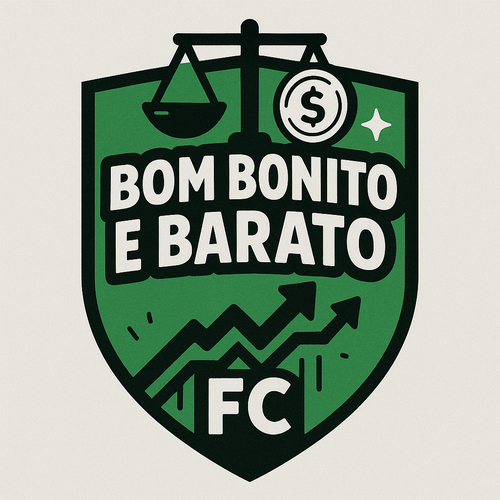

### Escalação:

Goleiro:

- Léo Linck	Athletico	- R$ 6.390.000,00

Defensores:

- Benjamín Gazzolo	Huachipato - R$ 6.390.000,00

- Willian Machado	Operário-PR	-	R$ 639.000,00

- David Ricardo	Ceará	- R$ 3.834.000,00

- Jermein Peña	Junior Barranquilla	- R$ 5.431.500,00

Meias:

- Guilherme	Santos - R$ 639.000,00

- Ramiro Vaca	Bolívar - R$ 5.112.000,00

- Lucas Ronier	Coritiba - R$ 2.556.000,00

Atacantes:

- Carlos Palacios	Colo Colo	- R$ 15.975.000,00

- Bruno Sávio	Bolívar	- R$ 4.153.500,00

- Hulk	Atlético Mineiro - R$ 11.502.000,00

Tecnicos:

- Carlos Gabriel - R$ 1.5

- Carlos Eduardo - R$ 2

### Preço do time - R$ 62M